# Day 9
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, rotation augmentation

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [54]:
class RotationBatch(BatchYielder):
    def __init__(self, header, datafile=None, augMult=8, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augMult = augMult
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData):
        vectors = [x[:-3] for x in inData.columns if '_px' in x]
        for vector in vectors:
            inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
            inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
                
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        self.rotate(inputs)
        
        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        inputs['aug_angle'] = np.linspace(0, 2*np.pi, self.augMult+1)[augIndex]
        self.rotate(inputs)

        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}

In [55]:
trainData = RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"))
valData = RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.217s 


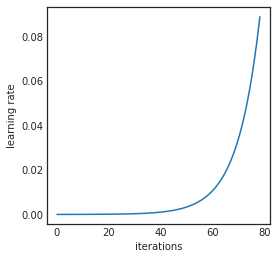

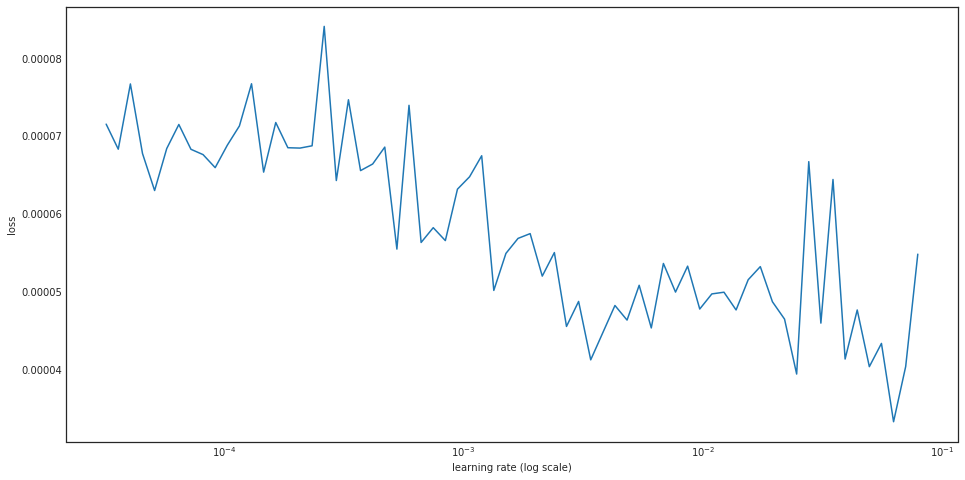

______________________________________



In [56]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [57]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.29754867966e-05
2 New best found: 3.85145569419e-05
3 New best found: 3.76568256623e-05
4 New best found: 3.68163553372e-05
5 New best found: 3.5860371621e-05
9 New best found: 3.58017383734e-05
10 New best found: 3.56785181627e-05
11 New best found: 3.53387629716e-05
12 New best found: 3.53180714834e-05
13 New best found: 3.49314922802e-05
14 New best found: 3.47756437791e-05
15 New best found: 3.47065864062e-05
22 New best found: 3.45548240804e-05
24 New best found: 3.42157443735e-05
26 New best found: 3.42120915972e-05
27 New best found: 3.41946419408e-05
29 New best found: 3.40534247777e-05
30 New best found: 3.40293088698e-05
42 New best found: 3.37702820003e-05
49 New best found: 3.36225137278e-05
51 New best found: 3.35946509182e-05
52 New best found: 3.35720093607e-05
55 New best found: 3.35436328731e-05
56 New best found: 3.35021215772e-05
59 New best 

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216564). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109933). Check your callbacks.
  % delta_t_median)


1 New best found: 4.38570213975e-05
2 New best found: 3.7550617463e-05
3 New best found: 3.69660143413e-05
4 New best found: 3.61235871254e-05
5 New best found: 3.55024329409e-05
6 New best found: 3.52493837619e-05
7 New best found: 3.51049191269e-05
9 New best found: 3.48751908137e-05
10 New best found: 3.44096681404e-05
11 New best found: 3.43143648052e-05
12 New best found: 3.41443499217e-05
13 New best found: 3.40256348642e-05
14 New best found: 3.3725714166e-05
17 New best found: 3.37239992574e-05
21 New best found: 3.35572476398e-05
22 New best found: 3.33528483002e-05
25 New best found: 3.31404863612e-05
26 New best found: 3.31115064934e-05
27 New best found: 3.29508193804e-05
28 New best found: 3.29141004481e-05
31 New best found: 3.28573162178e-05
47 New best found: 3.26841252206e-05
48 New best found: 3.25296159744e-05
51 New best found: 3.25028143823e-05
53 New best found: 3.24488256844e-05
54 New best found: 3.242901988e-05
55 New best found: 3.23413658977e-05
57 New best f

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133578). Check your callbacks.
  % delta_t_median)


1 New best found: 4.50908902422e-05
2 New best found: 4.03960437354e-05
3 New best found: 3.9476115259e-05
4 New best found: 3.77988865028e-05
5 New best found: 3.63785457285e-05
6 New best found: 3.62831198068e-05
7 New best found: 3.59697197929e-05
9 New best found: 3.57984711656e-05
10 New best found: 3.54135377418e-05
11 New best found: 3.50032524405e-05
12 New best found: 3.49457952323e-05
13 New best found: 3.4863372514e-05
14 New best found: 3.47743702641e-05
15 New best found: 3.47363381881e-05
18 New best found: 3.46068847855e-05
21 New best found: 3.43961249816e-05
23 New best found: 3.43846044005e-05
24 New best found: 3.43683013113e-05
25 New best found: 3.40116336786e-05
26 New best found: 3.39496569598e-05
28 New best found: 3.38750707727e-05
40 New best found: 3.38490506942e-05
41 New best found: 3.38214853847e-05
43 New best found: 3.37616072571e-05
47 New best found: 3.36107553158e-05
50 New best found: 3.34729493436e-05
51 New best found: 3.34458232535e-05
52 New best

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124133). Check your callbacks.
  % delta_t_median)


1 New best found: 4.25780454396e-05
2 New best found: 3.90604196724e-05
3 New best found: 3.84550158146e-05
5 New best found: 3.68043346175e-05
6 New best found: 3.63414815863e-05
7 New best found: 3.62873869417e-05
9 New best found: 3.61284780072e-05
10 New best found: 3.57390489736e-05
11 New best found: 3.53898108238e-05
12 New best found: 3.53856782662e-05
13 New best found: 3.50224971755e-05
21 New best found: 3.48718619331e-05
22 New best found: 3.48018830433e-05
23 New best found: 3.46060238055e-05
24 New best found: 3.44755847815e-05
25 New best found: 3.43852824243e-05
26 New best found: 3.42866042294e-05
27 New best found: 3.42387584147e-05
28 New best found: 3.41862644914e-05
29 New best found: 3.41563506304e-05
30 New best found: 3.3990277667e-05
43 New best found: 3.39595825947e-05
46 New best found: 3.39426649765e-05
50 New best found: 3.37696230031e-05
52 New best found: 3.37244136855e-05
54 New best found: 3.36700411044e-05
55 New best found: 3.36329500523e-05
58 New be

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153421). Check your callbacks.
  % delta_t_median)


1 New best found: 4.42954282218e-05
2 New best found: 3.89431342654e-05
3 New best found: 3.79686009968e-05
4 New best found: 3.70737114599e-05
5 New best found: 3.59711231956e-05
6 New best found: 3.53752395677e-05
9 New best found: 3.52781551779e-05
10 New best found: 3.5241404559e-05
11 New best found: 3.46267548715e-05
12 New best found: 3.42404593321e-05
13 New best found: 3.41493222712e-05
15 New best found: 3.39984424646e-05
21 New best found: 3.3799075269e-05
22 New best found: 3.36933465063e-05
23 New best found: 3.36224875719e-05
24 New best found: 3.33821275338e-05
25 New best found: 3.33272894227e-05
27 New best found: 3.32629403572e-05
28 New best found: 3.30967986033e-05
31 New best found: 3.30937908798e-05
41 New best found: 3.29337095289e-05
46 New best found: 3.28045303534e-05
48 New best found: 3.27715021226e-05
51 New best found: 3.26947767686e-05
53 New best found: 3.26350617147e-05
54 New best found: 3.25578968433e-05
55 New best found: 3.25416820808e-05
57 New bes

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163782). Check your callbacks.
  % delta_t_median)


1 New best found: 4.28845419755e-05
2 New best found: 3.80152399356e-05
3 New best found: 3.75233745103e-05
4 New best found: 3.6521021937e-05
5 New best found: 3.58004517888e-05
6 New best found: 3.5705701518e-05
7 New best found: 3.54250706222e-05
10 New best found: 3.53958774076e-05
11 New best found: 3.47595006628e-05
12 New best found: 3.46463351742e-05
13 New best found: 3.43509407221e-05
19 New best found: 3.41054822033e-05
21 New best found: 3.38689366647e-05
23 New best found: 3.36835763947e-05
24 New best found: 3.36265161281e-05
25 New best found: 3.34576518665e-05
30 New best found: 3.34242651884e-05
31 New best found: 3.3423743738e-05
44 New best found: 3.31589674919e-05
46 New best found: 3.30036688871e-05
52 New best found: 3.29663119284e-05
54 New best found: 3.2874324772e-05
57 New best found: 3.28738543568e-05
58 New best found: 3.28622405516e-05
61 New best found: 3.28586930223e-05
62 New best found: 3.2727472559e-05
88 New best found: 3.26793720863e-05
91 New best f

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.551702). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276249). Check your callbacks.
  % delta_t_median)


1 New best found: 4.21533023717e-05
2 New best found: 3.76816038724e-05
3 New best found: 3.66817349266e-05
4 New best found: 3.57306785527e-05
5 New best found: 3.52555264311e-05
6 New best found: 3.49643930635e-05
7 New best found: 3.48417486299e-05
8 New best found: 3.48246819803e-05
9 New best found: 3.44645200478e-05
10 New best found: 3.42049719563e-05
11 New best found: 3.40989031101e-05
12 New best found: 3.40538417102e-05
13 New best found: 3.39050345536e-05
14 New best found: 3.36925504179e-05
21 New best found: 3.36099076088e-05
22 New best found: 3.33218462931e-05
24 New best found: 3.30357975847e-05
25 New best found: 3.2947829368e-05
27 New best found: 3.29311295567e-05
28 New best found: 3.27999663311e-05
29 New best found: 3.27772117298e-05
34 New best found: 3.27685089673e-05
41 New best found: 3.26786331963e-05
45 New best found: 3.26501918594e-05
46 New best found: 3.24620490128e-05
49 New best found: 3.24430988368e-05
51 New best found: 3.23883699895e-05
53 New best

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196256). Check your callbacks.
  % delta_t_median)


1 New best found: 4.31803470061e-05
2 New best found: 3.86026483287e-05
3 New best found: 3.7397439792e-05
4 New best found: 3.61855310618e-05
5 New best found: 3.56965385543e-05
6 New best found: 3.52226305856e-05
9 New best found: 3.51550180871e-05
10 New best found: 3.46119792695e-05
11 New best found: 3.44670649483e-05
12 New best found: 3.42358910717e-05
13 New best found: 3.41260793501e-05
14 New best found: 3.40432740311e-05
19 New best found: 3.38932929513e-05
20 New best found: 3.36801970754e-05
23 New best found: 3.36136172282e-05
24 New best found: 3.32978913109e-05
25 New best found: 3.32457150311e-05
26 New best found: 3.32205234151e-05
27 New best found: 3.29959110492e-05
28 New best found: 3.2946024608e-05
31 New best found: 3.29419034899e-05
40 New best found: 3.28875060812e-05
43 New best found: 3.27492983929e-05
44 New best found: 3.27073705139e-05
47 New best found: 3.26863411755e-05
49 New best found: 3.26035360951e-05
50 New best found: 3.25774688735e-05
51 New bes

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207284). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104042). Check your callbacks.
  % delta_t_median)


1 New best found: 4.29621905086e-05
2 New best found: 3.87697760949e-05
3 New best found: 3.7942398521e-05
4 New best found: 3.64850452398e-05
5 New best found: 3.58947056358e-05
6 New best found: 3.52824692254e-05
7 New best found: 3.52214014899e-05
9 New best found: 3.46701566092e-05
10 New best found: 3.43446201815e-05
11 New best found: 3.42535287377e-05
12 New best found: 3.42275012742e-05
13 New best found: 3.39526591576e-05
20 New best found: 3.39396948909e-05
21 New best found: 3.39023145306e-05
22 New best found: 3.3744439353e-05
24 New best found: 3.35245625242e-05
25 New best found: 3.34366678013e-05
26 New best found: 3.32490023661e-05
29 New best found: 3.31205819294e-05
30 New best found: 3.30152148327e-05
44 New best found: 3.29382885215e-05
46 New best found: 3.27987712408e-05
48 New best found: 3.26506096388e-05
55 New best found: 3.26084683523e-05
56 New best found: 3.25716365111e-05
58 New best found: 3.2524656923e-05
61 New best found: 3.24342378779e-05
88 New best 

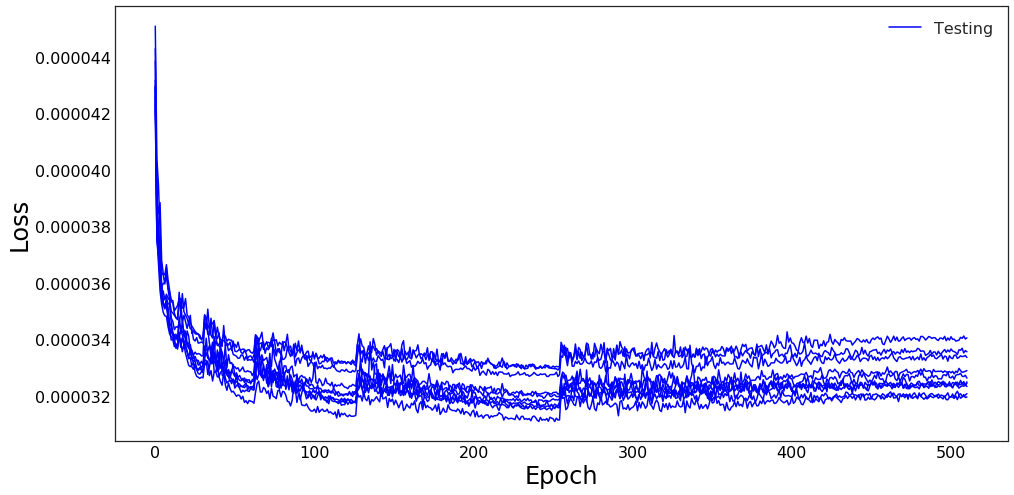

Mean wAUC = 0.0645 +- 0.0007
______________________________________



In [58]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [59]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [60]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.110186173813499e-05
Model 1 is 2 with loss = 3.149156671751852e-05
Model 2 is 8 with loss = 3.158000014466575e-05
Model 3 is 7 with loss = 3.163253870031559e-05
Model 4 is 9 with loss = 3.169450663676961e-05
Model 5 is 5 with loss = 3.192054898237487e-05
Model 6 is 6 with loss = 3.203069043982587e-05
Model 7 is 3 with loss = 3.269235153926564e-05
Model 8 is 4 with loss = 3.29240844411122e-05
Model 9 is 0 with loss = 3.2976034126695485e-05


In [62]:
np.mean([3.110186173813499e-05,
3.149156671751852e-05,
3.158000014466575e-05,
3.163253870031559e-05,
3.169450663676961e-05,
3.192054898237487e-05,
3.203069043982587e-05,
3.269235153926564e-05,
3.29240844411122e-05,
3.2976034126695485e-05])

3.2004418346667855e-05

## Response on development data

In [63]:
def batchEnsemblePredict(ensemble, weights, data, predName='pred', nOut=1, outputPipe=None, ensembleSize=None, nFolds=-1, verbose=False):
    if isinstance(ensembleSize, types.NoneType):
        ensembleSize = len(ensemble)

    if not isinstance(data, BatchYielder):
        data = BatchYielder(data)

    if nFolds < 0:
        nFolds = len(data.source)

    for fold in range(nFolds):
        if verbose:
            print 'Predicting batch {} out of {}'.format(fold+1, nFolds)
            start = timeit.default_timer()

        if not data.testTimeAug:
            batch = data.getBatch(fold)['inputs']
            batchPred = ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe)

        else:
            tmpPred = []
            for aug in range(data.augMult):
                batch = data.getTestBatch(fold, aug)['inputs']
                tmpPred.append(ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe))
            batchPred = np.mean(tmpPred, axis=0)

        if verbose: 
            print "Prediction took {}s per sample\n".format((timeit.default_timer() - start)/len(batch))

        if nOut > 1:
            saveBatchPred(batchPred, 'fold_' + str(fold), data.source, predName=predName)
        else:
            saveBatchPred(batchPred[:,0], 'fold_' + str(fold), data.source, predName=predName)

In [66]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00224691946193s per sample

Predicting batch 2 out of 10
Prediction took 0.00201860967085s per sample

Predicting batch 3 out of 10
Prediction took 0.00212204734669s per sample

Predicting batch 4 out of 10
Prediction took 0.00191121860743s per sample

Predicting batch 5 out of 10
Prediction took 0.00195363324881s per sample

Predicting batch 6 out of 10
Prediction took 0.00208647555113s per sample

Predicting batch 7 out of 10
Prediction took 0.00192181780338s per sample

Predicting batch 8 out of 10
Prediction took 0.00210880243729s per sample

Predicting batch 9 out of 10
Prediction took 0.00198078389179s per sample

Predicting batch 10 out of 10
Prediction took 0.00201670068092s per sample



In [67]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source)),
                                                            roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source), sample_weight=getFeature('weights', trainData.source)))

Training ROC AUC: unweighted 0.905658896419, weighted 0.940667668454


## Response on val data

In [68]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00231751422882s per sample

Predicting batch 2 out of 10
Prediction took 0.00258626337051s per sample

Predicting batch 3 out of 10
Prediction took 0.00233713297844s per sample

Predicting batch 4 out of 10
Prediction took 0.00208042702675s per sample

Predicting batch 5 out of 10
Prediction took 0.00252763719559s per sample

Predicting batch 6 out of 10
Prediction took 0.00224880156517s per sample

Predicting batch 7 out of 10
Prediction took 0.00202807340622s per sample

Predicting batch 8 out of 10
Prediction took 0.00200930643082s per sample

Predicting batch 9 out of 10
Prediction took 0.00241410779953s per sample

Predicting batch 10 out of 10
Prediction took 0.00431299781799s per sample



In [69]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.902602125367, weighted 0.935080650887


## Evaluation

### Import in dataframe

In [70]:
valframe = convertToDF(valData.source)

50000 candidates loaded


In [71]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

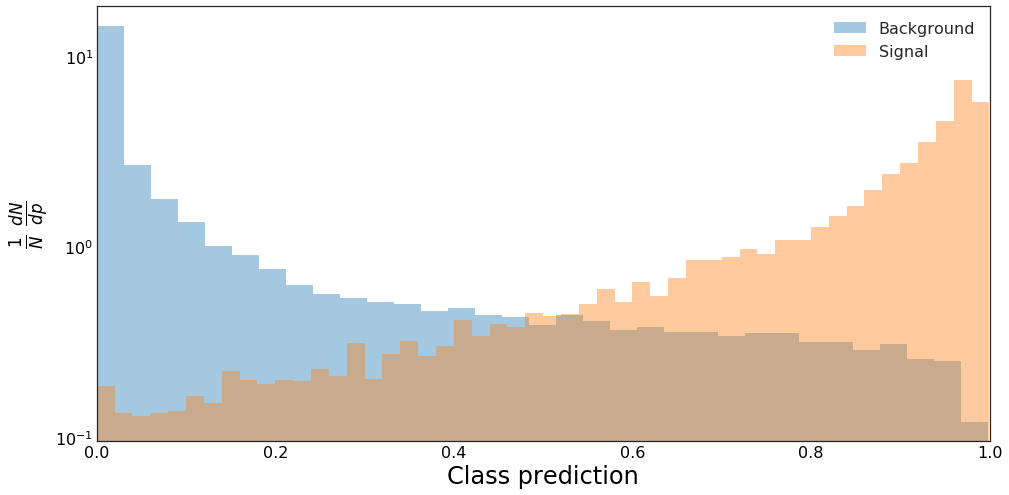

In [72]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [73]:
valframe['ams'] = amsScan(valframe)[0]

[0.962036669254303, 1.715338062853555]


In [74]:
bests = foldAMSScan(valframe, 10)

[0.9827142357826233, 1.902247710046677]
Fold 0, best AMS 1.90224771005 at cut of 0.982714235783. Total weights Signal:Bkg. 14.1793880463:8247.75488281


../Modules/Basics.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
../Modules/Basics.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))


[0.9622649550437927, 2.07348513187865]
Fold 1, best AMS 2.07348513188 at cut of 0.962264955044. Total weights Signal:Bkg. 13.6036272049:8172.96777344
[0.9620826840400696, 1.9042538362196422]
Fold 2, best AMS 1.90425383622 at cut of 0.96208268404. Total weights Signal:Bkg. 13.7179203033:8123.82324219
[0.9606154561042786, 1.792975205207192]
Fold 3, best AMS 1.79297520521 at cut of 0.960615456104. Total weights Signal:Bkg. 13.5145053864:8063.17285156
[0.9762563109397888, 2.0260602661207536]
Fold 4, best AMS 2.02606026612 at cut of 0.97625631094. Total weights Signal:Bkg. 13.3408737183:8297.80078125
[0.9558965563774109, 1.8633130666654862]
Fold 5, best AMS 1.86331306667 at cut of 0.955896556377. Total weights Signal:Bkg. 13.9258365631:8187.23144531
[0.9499762654304504, 1.869285015501728]
Fold 6, best AMS 1.8692850155 at cut of 0.94997626543. Total weights Signal:Bkg. 13.6173152924:8101.94140625
[0.9822077751159668, 2.429943345857244]
Fold 7, best AMS 2.42994334586 at cut of 0.982207775116.

In [76]:
batchEnsemblePredict(ensemble, weights, RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+")), ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00220413945371s per sample

Predicting batch 2 out of 10
Prediction took 0.00206985276396s per sample

Predicting batch 3 out of 10
Prediction took 0.00234522937861s per sample

Predicting batch 4 out of 10
Prediction took 0.00214714870886s per sample

Predicting batch 5 out of 10
Prediction took 0.00260534796281s per sample

Predicting batch 6 out of 10
Prediction took 0.00293035368919s per sample

Predicting batch 7 out of 10
Prediction took 0.00212469470718s per sample

Predicting batch 8 out of 10
Prediction took 0.00218649663492s per sample

Predicting batch 9 out of 10
Prediction took 0.00264680543379s per sample

Predicting batch 10 out of 10
Prediction took 0.00237808450786s per sample



In [85]:
saveTest(0.96, 'Day_9_96')

../Data/Day_9_96_test.csv


In [86]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_9_96_test.csv -m"Day_9 1e-3 96"

Successfully submitted to Higgs Boson Machine Learning Challenge